In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score,recall_score,accuracy_score,precision_score
import matplotlib.pyplot as plt

In [3]:
from data_loaders import load_dataset, load_inference_data, promptTechList, modelList, problem_list,accuracy
import sys
sys.path.append('../')

def evaluate_problem(problem : str) -> dict[str, dict[str, list[int]]]:

    # formate the problem and its name
    problem_name = problem
    match problem:
        case 'Direct Boolean Computation'|'DirectBooleanComputation':
            from DirectBooleanComputation import response_evaluator
            problem = 'DirectBooleanComputation'
            problem_name = 'Direct Boolean Computation'

        case 'Indirect Boolean Computation'|'IndirectBooleanComputation':
            from IndirectBooleanComputation import response_evaluator
            problem = 'IndirectBooleanComputation'
            problem_name = 'Indirect Boolean Computation'
        
        case 'SAT':
            from SAT import response_evaluator
        
        case 'SAT Count'|'SATCount':
            from SATCount import response_evaluator
            problem = 'SATCount'
            problem_name = 'SAT Count'
        
        case 'TautologyQ':
            from TautologyQ import response_evaluator
        
        case 'EquivalentQ':
            from EquivalentQ import response_evaluator
        
        case 'CNF':
            from CNF import response_evaluator
        
        case 'DNF':
            from DNF import response_evaluator

    # load corresponding dataset
    dataset = load_dataset(problem)

    inference_data = {
        model: {p: load_inference_data(
            problem, p, model) for p in promptTechList}
        for model in modelList
    }
    # evaluate all the reponses
    evaluation_result = {
        model : {
            p: [
                response_evaluator(response['response'], dataObject)
                for dataObject, response in zip(dataset, inference_data[model][p])
            ]
        for p in promptTechList}
    for model in modelList
    }

    return evaluation_result

### ratio

In [7]:
def ratio_analysis(problem, model, prompt):
    res = evaluate_problem(problem)
    dataset = load_dataset(problem)
    y_true = [data[problem] if problem in data.keys() else data['Answer'] for data in dataset]
    y_pred  = [not (x ^ bool(y)) for x,y in zip(y_true, res[model][prompt])]
    
    return sum(y_pred) / (len(y_pred) - sum(y_pred) )

In [8]:
res = [[
    ratio_analysis(problem, 'llama2-13b', prompt)
    for problem in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
]for prompt in ['Few-shot', 'CoT']]

In [9]:
res

[[4.708652373660031, 18.095270733379028, 42.3328530259366, 1.9562376006535185],
 [1.0964499121265379,
  1.2232862500997526,
  1.3193737467221964,
  1.228556347321193]]

In [10]:
res = [[
    ratio_analysis(problem, 'wizardmath-13b', prompt)
    for problem in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
]for prompt in ['Few-shot', 'CoT']]

In [13]:
res

[[4.172043010752688,
  2.0066911288581912,
  1.0698602794411178,
  0.11767041694242224],
 [0.9802124833997344,
  1.025445292620865,
  1.3227774774078938,
  1.2154976386216547]]

In [12]:
[round(y,2) for x in res
    for y in x ]

[4.17, 2.01, 1.07, 0.12, 0.98, 1.03, 1.32, 1.22]

In [13]:
res = [[
    ratio_analysis(problem, model, prompt)
    for problem in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
    for model in modelList
]for prompt in ['Few-shot', 'CoT']]

In [16]:
res

[[0.8248273086982765,
  0.8066528066528067,
  0.9476310122038766,
  0.6674084709260588,
  0.9769228211352375,
  0.5168756027000965,
  0.6617321964313911,
  0.10528185693983894],
 [0.5230031520354101,
  0.49500368855207566,
  0.5502153625269203,
  0.5062814070351759,
  0.5688491337744821,
  0.5694809297376384,
  0.5512790146849834,
  0.5486341386388758]]

In [15]:
[sum(x) / len(x) for x in res]

[0.6884165094609478, 0.5390933533731952]

### Confusion Matrix

In [3]:
import matplotlib
a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

def confusion_matrix_analysis(problem, model, prompt, save_fig=True):
    res = evaluate_problem(problem)
    dataset = load_dataset(problem)
    y_true = [data[problem] if problem in data.keys() else data['Answer'] for data in dataset]
    y_pred  = [not (x ^ bool(y)) for x,y in zip(y_true, res[model][prompt])]
    parameters = {
        "font.family": 'SimSun',
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16
    }
    plt.rcParams.update(parameters)
    sns.set_theme('paper',font='SimSun',font_scale=3)
    f,ax = plt.subplots()
    C2 = confusion_matrix(y_true, y_pred)

    fig = sns.heatmap(C2, ax=ax, annot=True, fmt='.20g', xticklabels=('真','假'), yticklabels=('真','假'))

    plt.xlabel('预测值')
    plt.ylabel('真实值')
    if save_fig:
        plt.savefig(f"figs/{problem}-{model}-{prompt}-confusion-matrix.pdf", bbox_inches='tight')

    return C2

C:\Users\hp\AppData\Local\Temp\ipykernel_8268\629075922.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f,ax = plt.subplots()


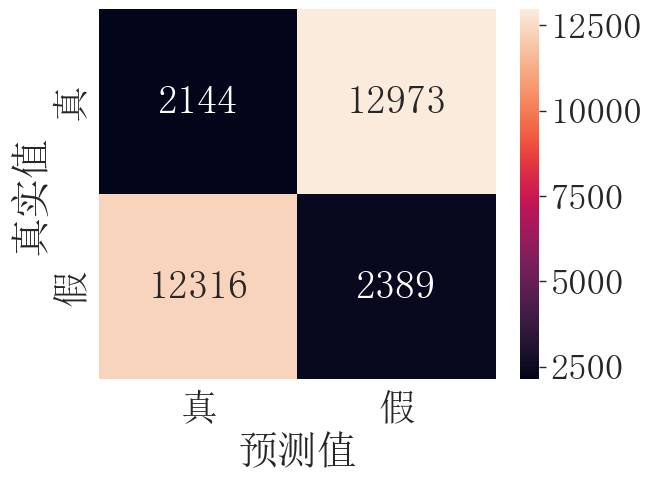

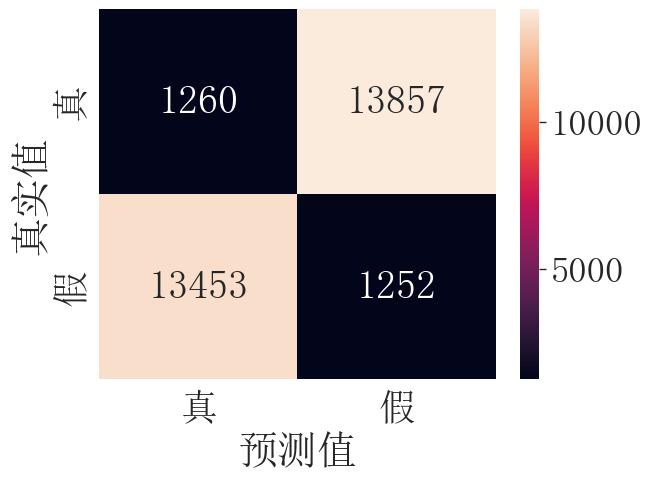

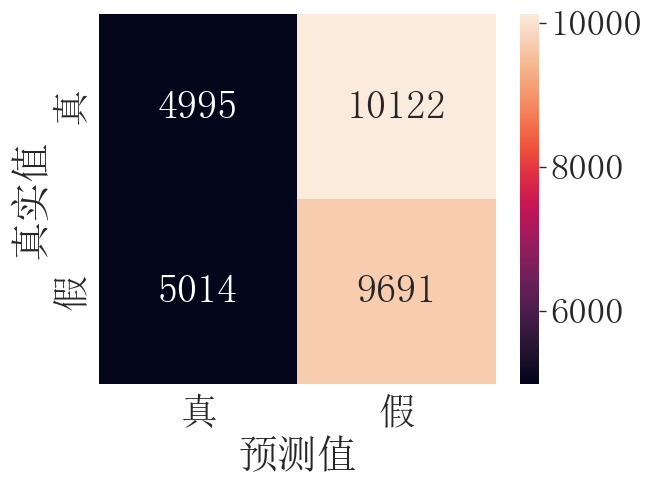

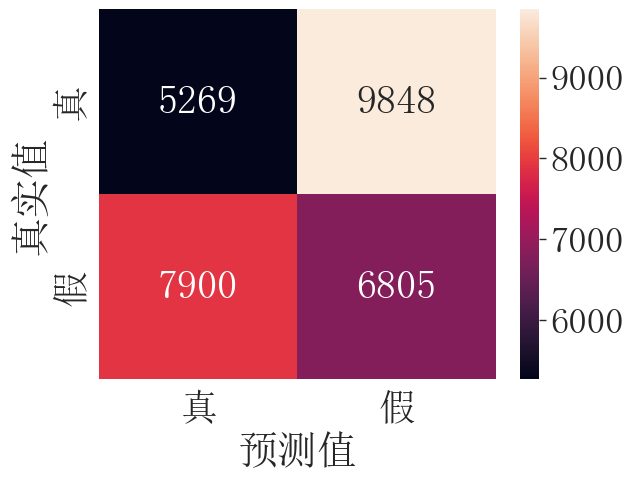

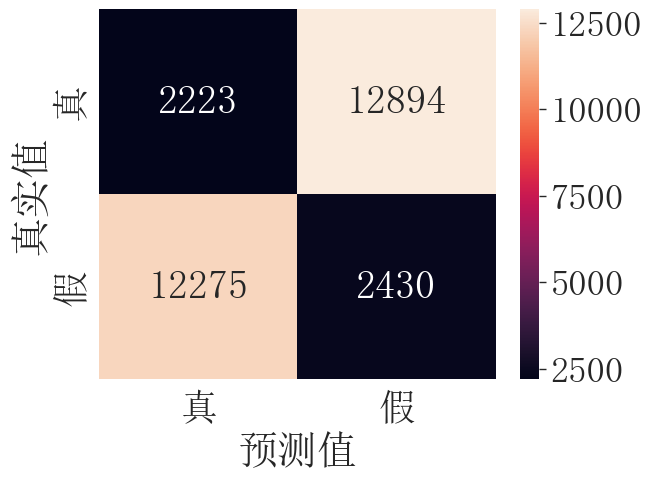

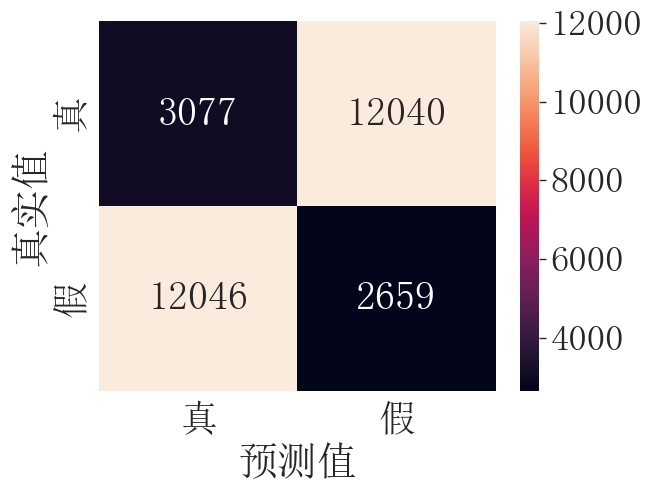

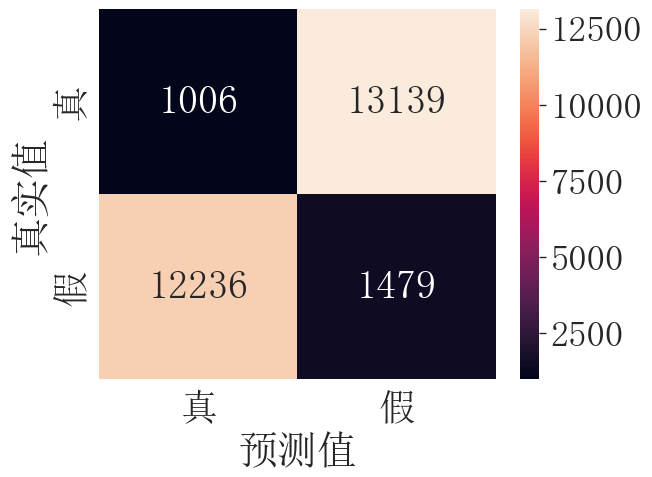

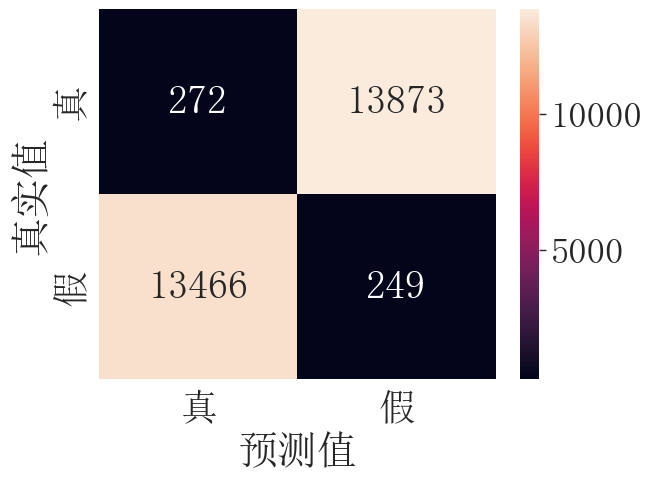

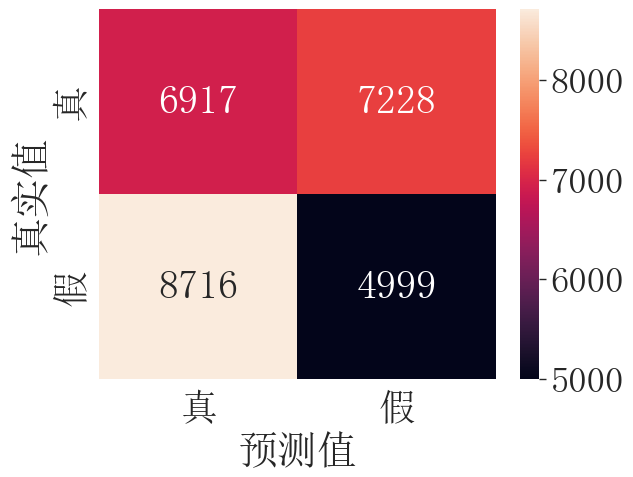

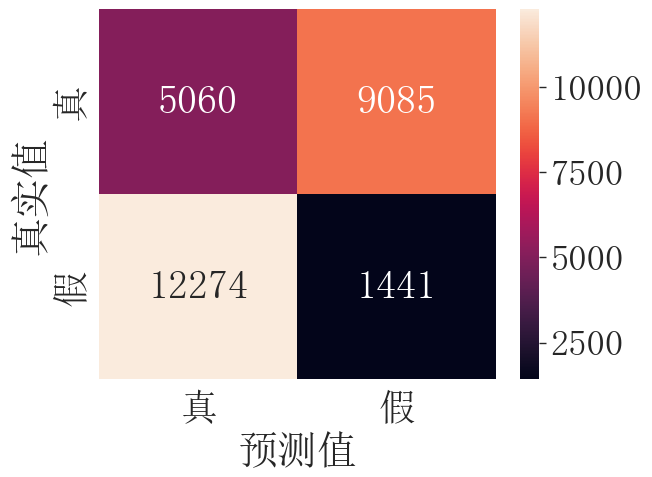

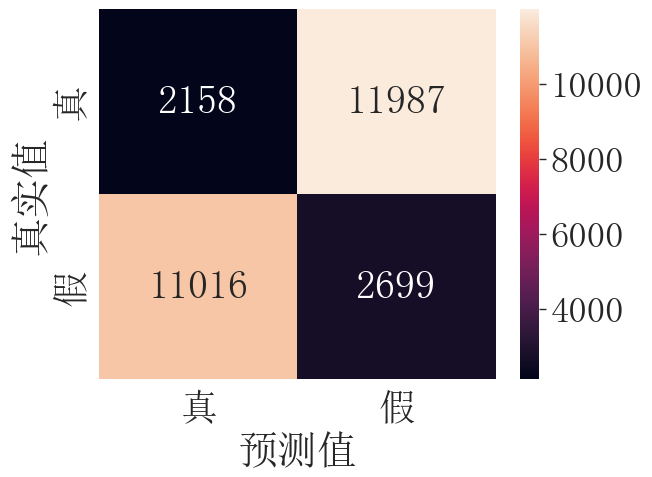

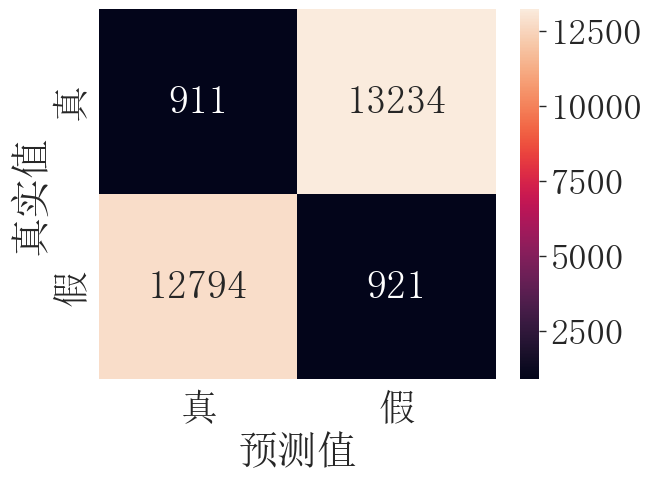

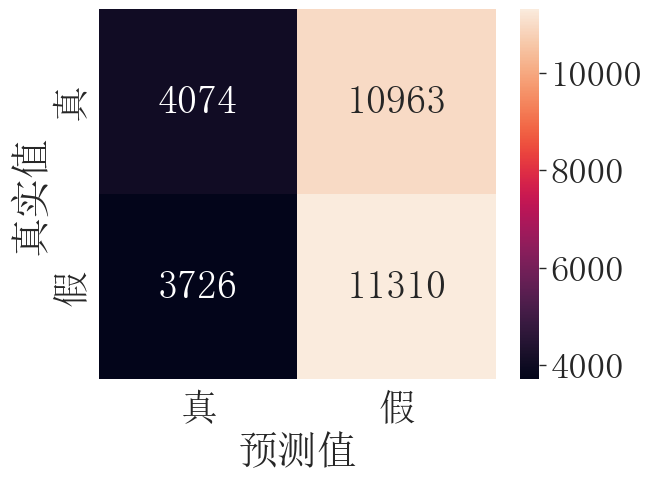

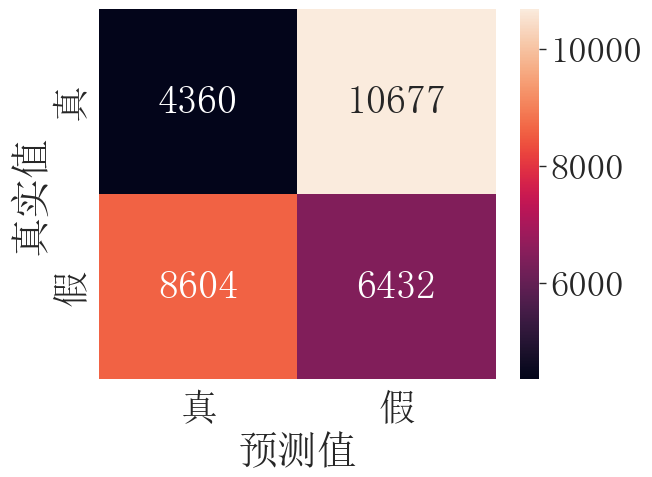

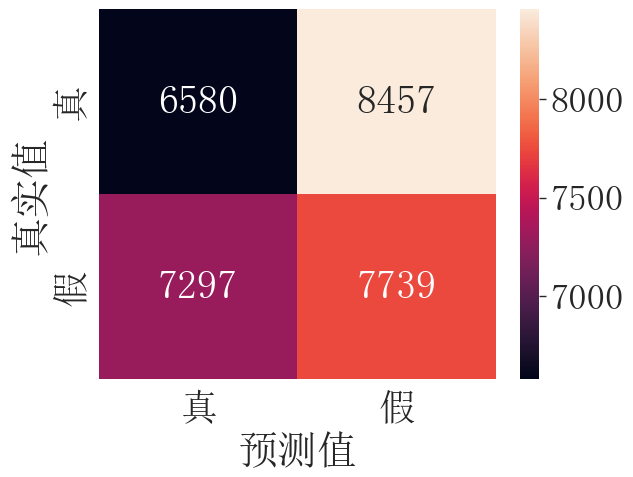

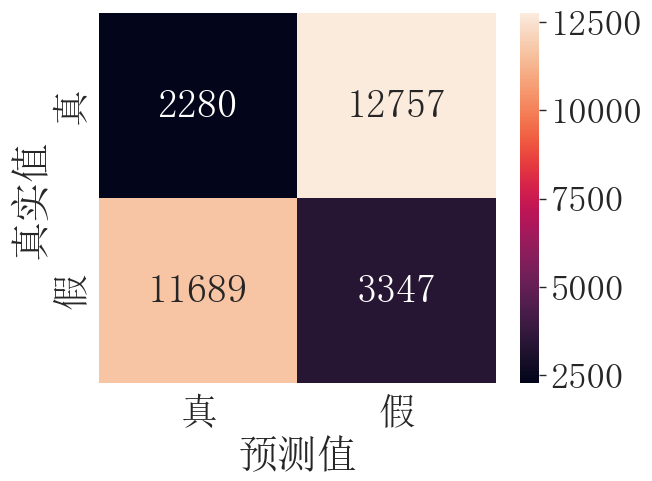

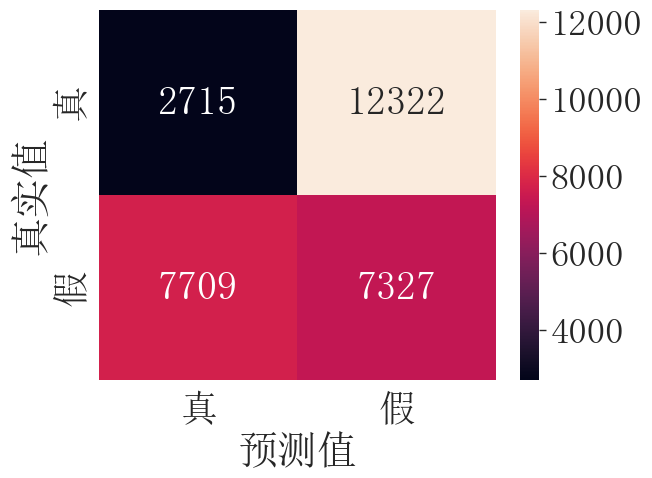

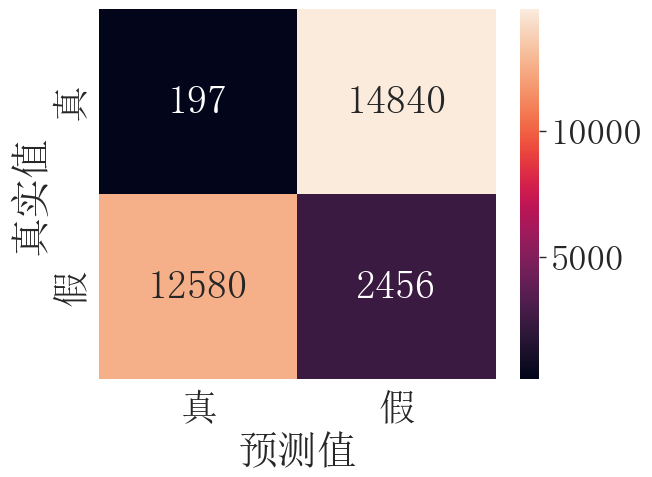

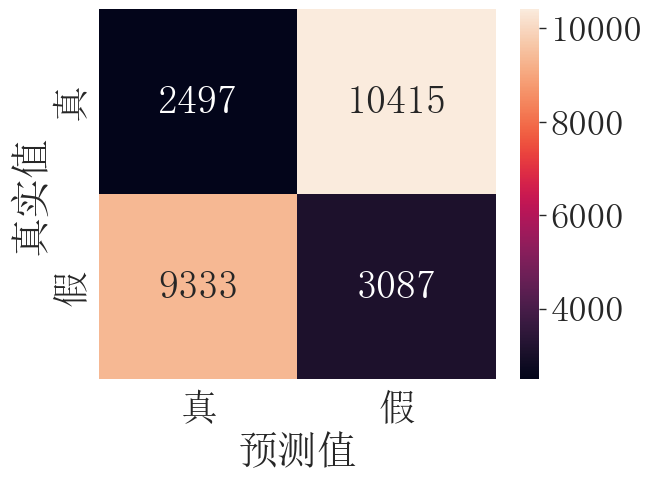

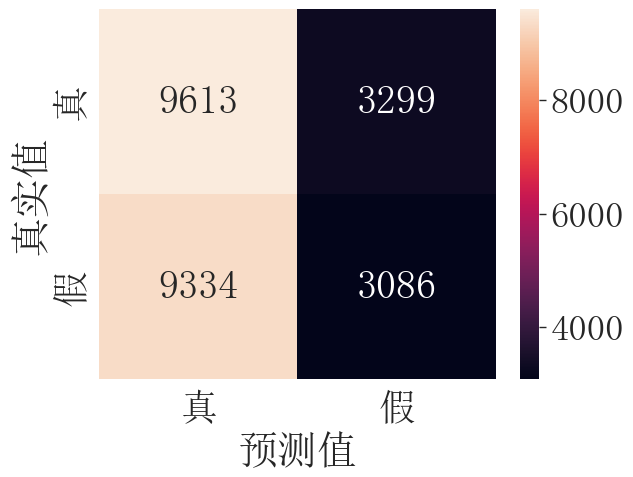

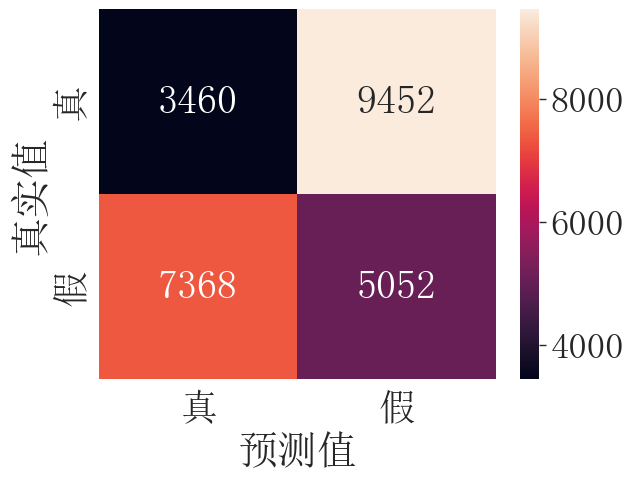

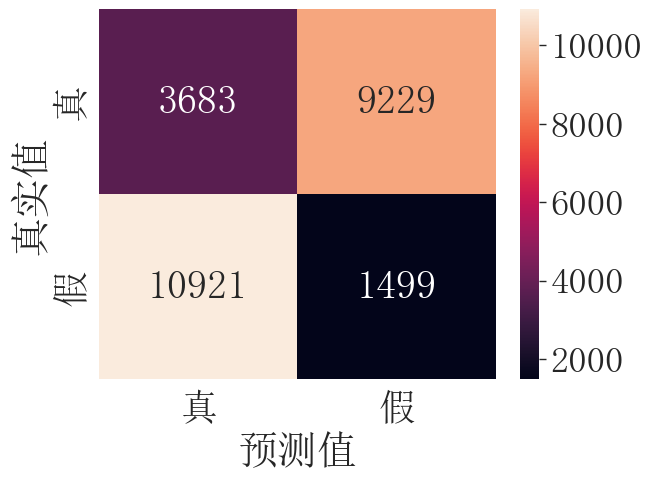

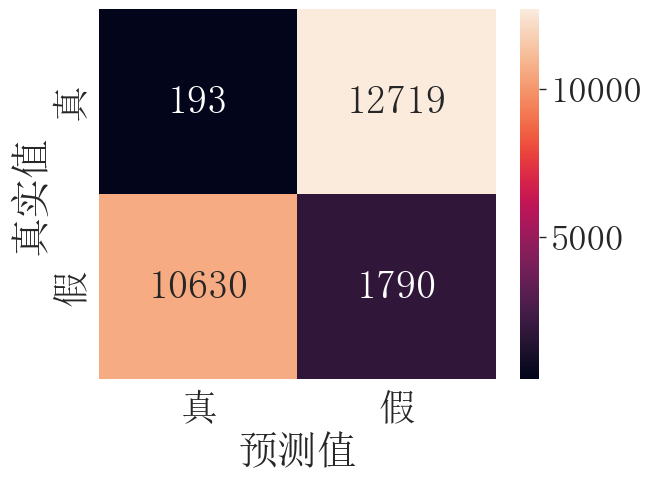

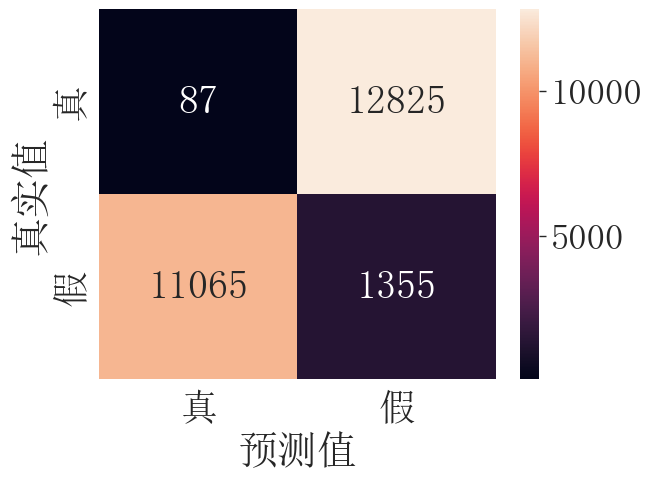

In [4]:
res = [
    confusion_matrix_analysis(problem, model, prompt,save_fig=True)
    for problem in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
    for prompt in ['Zero-shot', 'Few-shot-CoT','LtM']
    for model in modelList
]

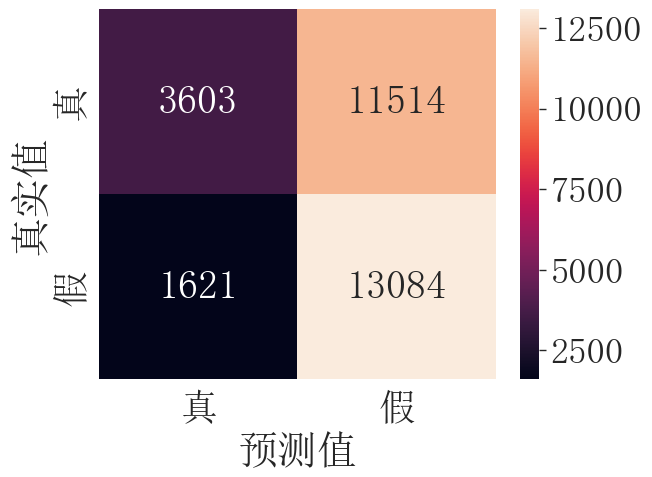

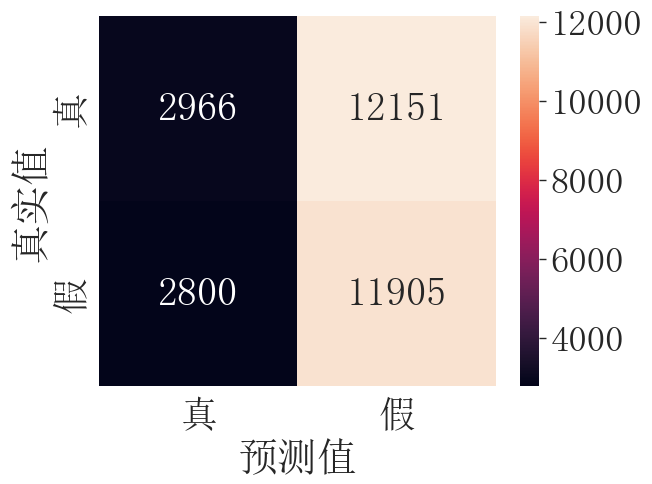

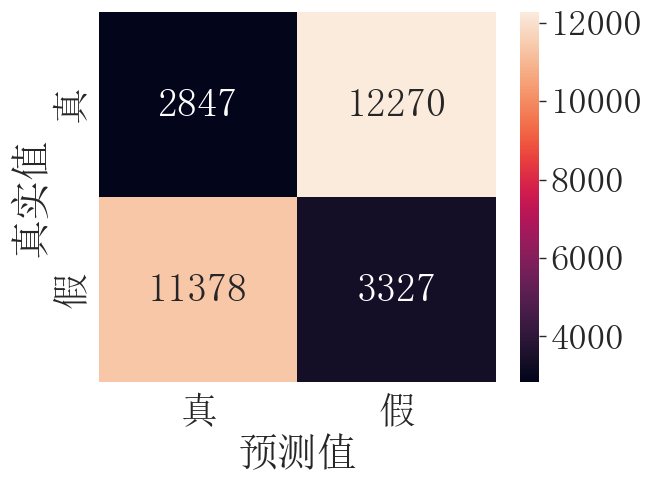

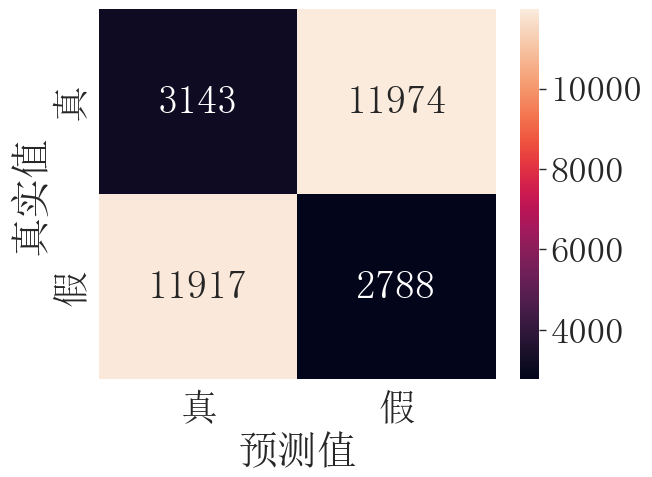

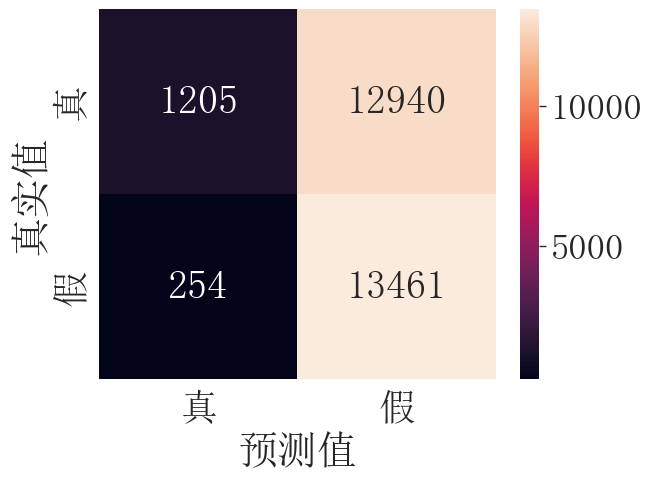

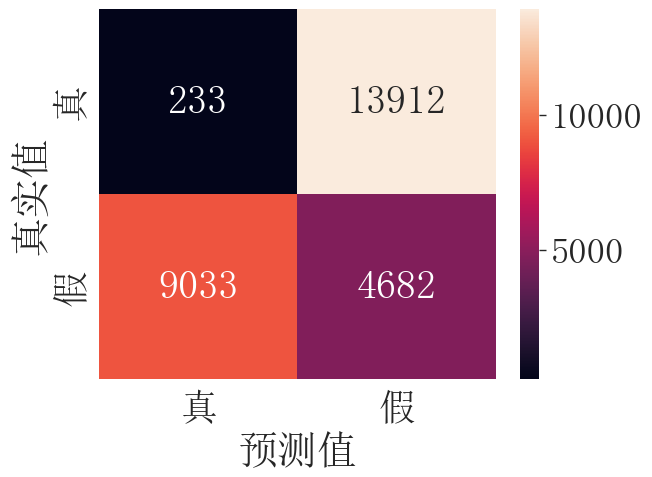

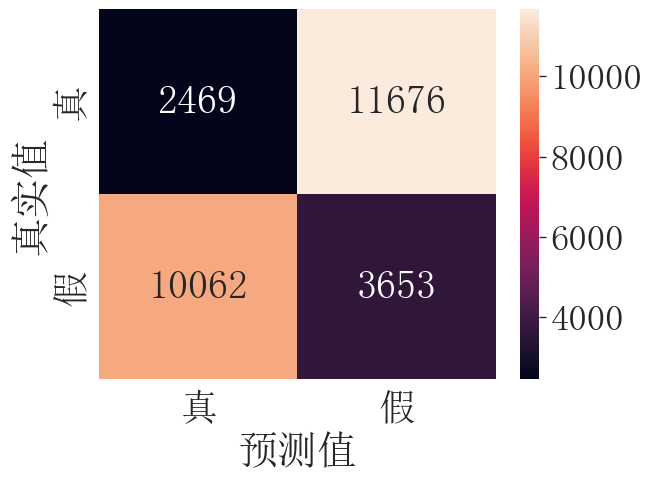

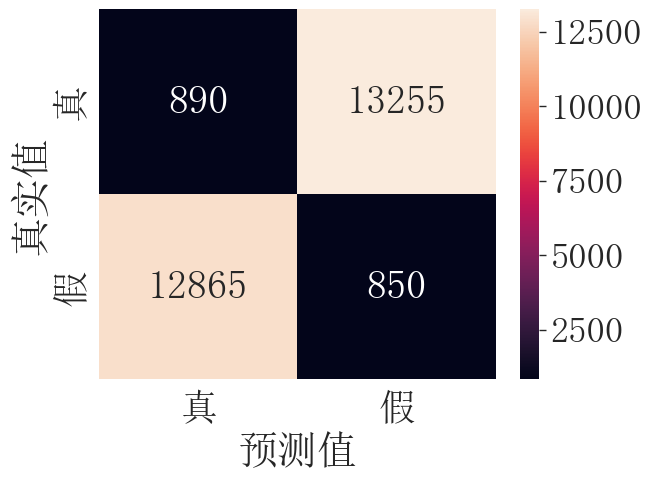

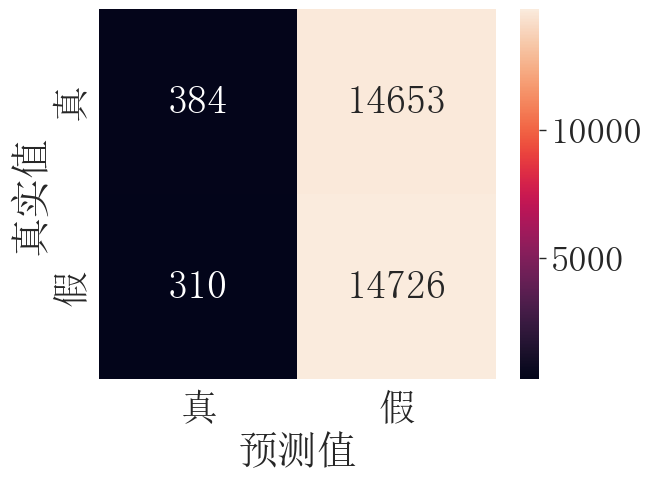

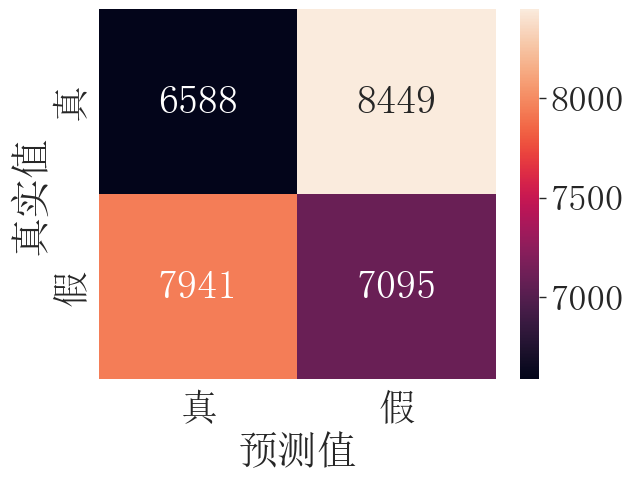

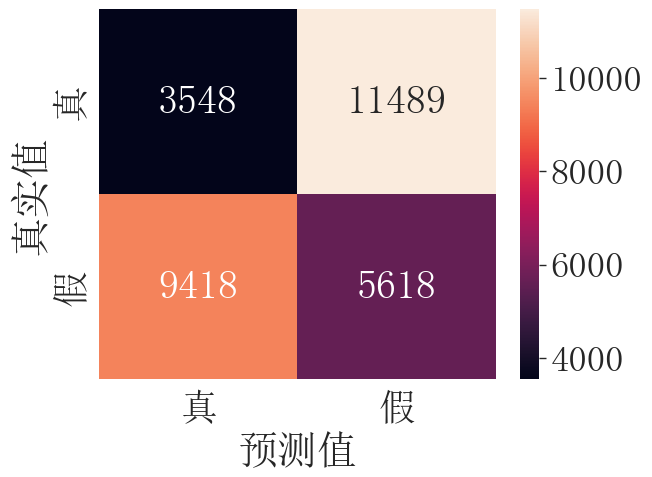

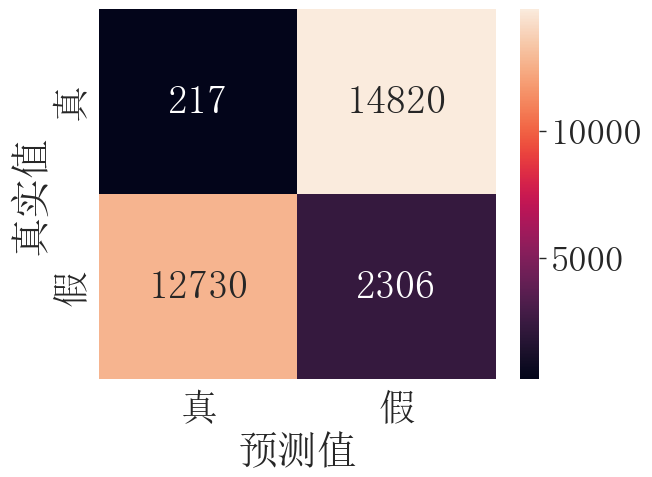

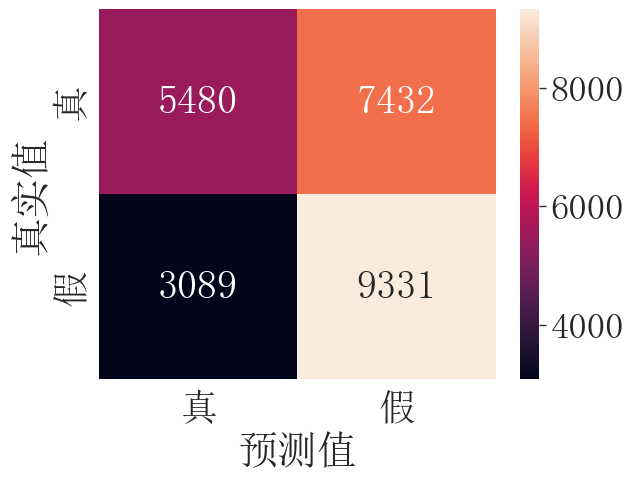

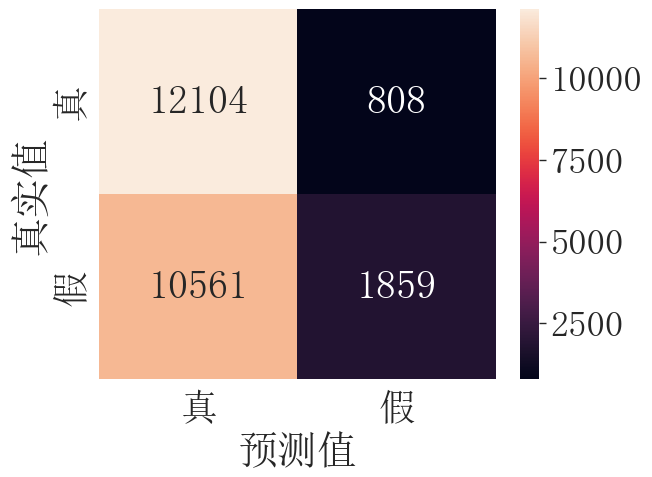

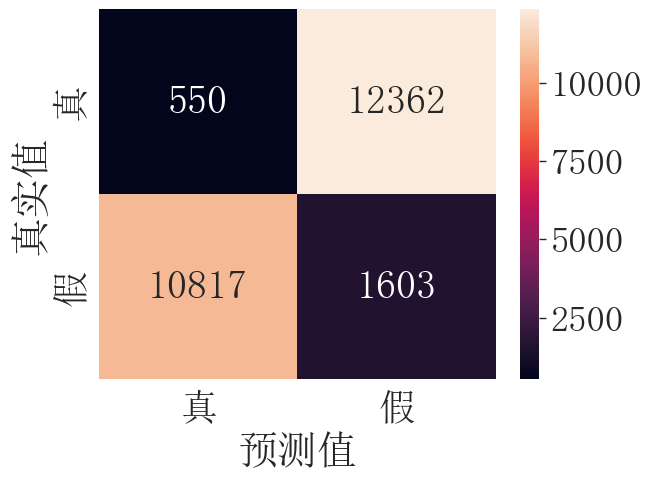

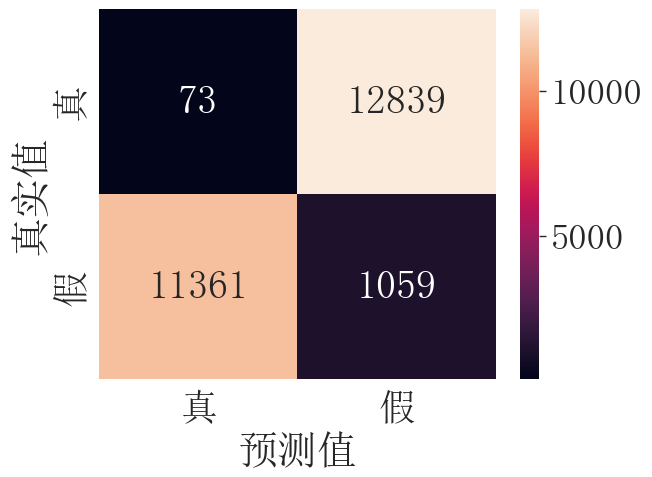

In [33]:
res = [
    confusion_matrix_analysis(problem, model, prompt,save_fig=True)
    for problem in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
    for prompt in ['Few-shot', 'CoT']
    for model in modelList
]

### f1 score

In [39]:
def f1_analyses(problem : str, model : str, prompt : str):
    res = evaluate_problem(problem)
    dataset = load_dataset(problem)
    y_true = [data[problem] if problem in data.keys() else data['Answer'] for data in dataset]
    y_pred  = [not (x ^ bool(y)) for x,y in zip(y_true, res[model][prompt])]
    return f1_score(y_true=y_true, y_pred=y_pred)

In [40]:
res = {
    (p, model, prompt) : f1_analyses(p, model, prompt)
        for p in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
        for model in modelList
        for prompt in promptTechList
}

In [42]:
{(p,model): str([round(res[(p, model, prompt)], 3) for prompt in promptTechList]).replace(',', ' &')
 for p in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
 for model in modelList
 }

{('DirectBooleanComputation',
  'llama2-13b'): '[0.159 & 0.666 & 0.162 & 0.22 & 0.562]',
 ('DirectBooleanComputation',
  'wizardmath-13b'): '[0.084 & 0.614 & 0.181 & 0.189 & 0.434]',
 ('IndirectBooleanComputation',
  'llama2-13b'): '[0.104 & 0.671 & 0.19 & 0.252 & 0.385]',
 ('IndirectBooleanComputation',
  'wizardmath-13b'): '[0.018 & 0.29 & 0.066 & 0.061 & 0.119]',
 ('TautologyQ', 'llama2-13b'): '[0.606 & 0.663 & 0.422 & 0.35 & 0.496]',
 ('TautologyQ', 'wizardmath-13b'): '[0.4 & 0.464 & 0.152 & 0.143 & 0.215]',
 ('EquivalentQ', 'llama2-13b'): '[0.238 & 0.639 & 0.133 & 0.122 & 0.375]',
 ('EquivalentQ', 'wizardmath-13b'): '[0.328 & 0.246 & 0.102 & 0.08 & 0.13]'}

In [44]:
{(p,model): str([round(res[(p, model, 'Few-shot')] - res[(p, model, 'Zero-shot')], 3)]).replace(',', ' &')
 for p in ['DirectBooleanComputation','IndirectBooleanComputation','TautologyQ','EquivalentQ']
 for model in modelList
 }

{('DirectBooleanComputation', 'llama2-13b'): '[0.507]',
 ('DirectBooleanComputation', 'wizardmath-13b'): '[0.53]',
 ('IndirectBooleanComputation', 'llama2-13b'): '[0.567]',
 ('IndirectBooleanComputation', 'wizardmath-13b'): '[0.272]',
 ('TautologyQ', 'llama2-13b'): '[0.057]',
 ('TautologyQ', 'wizardmath-13b'): '[0.064]',
 ('EquivalentQ', 'llama2-13b'): '[0.401]',
 ('EquivalentQ', 'wizardmath-13b'): '[-0.082]'}